In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim":  #kj13
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
# from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats


In [6]:
## pattern enso, eq
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #shp or land fraction
# detrend?
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12) # get DEC
    #remove time mean
    cube = anomalies(cube,period='monthly')
    
    return cube

def sst_eq(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,12) # get DEC
# remove time mean
    cube = anomalies(cube, period='monthly')
    cube = meridional_statistics(cube, 'mean')

    return cube

#linear regression of sst_eq on sst_enso
def lin_regress(cube_ssta, cube_nino34): #1d
    slope_ls = []
    for lon_slice in cube_ssta.slices(['time']): # iterate over 120 lon points
        res = scipy.stats.linregress(lon_slice.data, cube_nino34.data)
        slope_ls.append(res[0])

    return cube_ssta.coord('longitude').points, slope_ls
    
# rmse = np.sqrt(np.mean((obs_regressed - model_regressed) ** 2))

In [7]:
model_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

Text(0.5, 0.95, 'RMSE: 0.47 ')

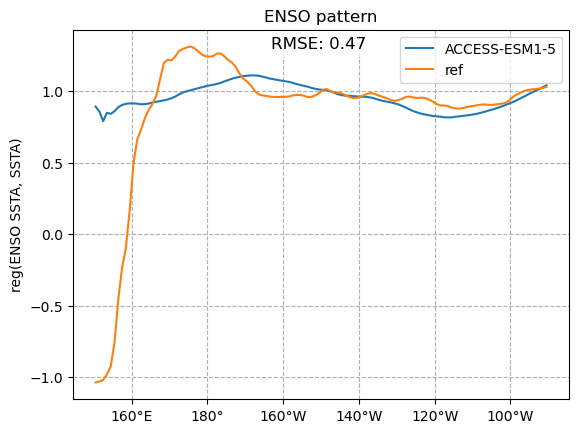

In [21]:
## linear regression sst_eq on sst_enso

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'


reg_mod = lin_regress(model_datasets_prep2["ACCESS-ESM1-5"], model_datasets_prep1["ACCESS-ESM1-5"])

# return slope data to longitude - array?
plt.plot(reg_mod[0], reg_mod[1], label="ACCESS-ESM1-5") #units

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

reg = lin_regress(obs_datasets_prep2["HadISST"], obs_datasets_prep1["HadISST"])
plt.plot(reg[0],reg[1], label='ref')

plt.ylabel("reg(ENSO SSTA, SSTA)")
plt.title('ENSO pattern') #
plt.legend()
plt.grid(linestyle='--')

rmse = np.sqrt(np.mean((np.array(reg[1]) - np.array(reg_mod[1])) ** 2)) #metric

plt.text(0.5, 0.95, f"RMSE: {rmse:.2f} ", fontsize=12, ha='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

## For 2d plots contour filled - regress 
- to do : from cube, 
- different preprocessors for 3d data not - (35,) (35, 120)

In [8]:
import numpy as np
import scipy.stats

model_nino34 = model_datasets_prep1["ACCESS-ESM1-5"].data
model_ssta = model_datasets_prep2["ACCESS-ESM1-5"].data

# Assuming ssta_data has dimensions (time, latitude, longitude)
# Flatten the spatial dimensions (latitude, longitude) to apply regression on each point
ssta_data_reshaped = model_ssta.reshape(model_ssta.shape[0], -1)  # Shape will be (time, latitude*longitude)
nino34_data_reshaped = np.squeeze(model_nino34)  # Shape (time,)

In [15]:
print(nino34_data_reshaped.shape, ssta_data_reshaped.shape, model_ssta.shape,model_nino34.shape, type(model_ssta))

(35,) (35, 120) (35, 120) (35,) <class 'numpy.ma.core.MaskedArray'>


In [16]:
# Ensure matching lengths
if ssta_data_reshaped.shape[0] != nino34_data_reshaped.shape[0]:
    raise ValueError("Shapes of ssta_data and nino34_data do not match.")

# Initialize arrays to store the regression results
slope_2d = np.full(ssta_data_reshaped.shape[1], np.nan)

# Calculate regression coefficient (slope) for each spatial point
for i in range(ssta_data_reshaped.shape[1]):
    # Perform regression on the flattened spatial point
    ssta_point = ssta_data_reshaped[:, i]

    # Check if all values in ssta_point are identical or if the data is not valid for regression
    if np.all(ssta_point == ssta_point[0]) or np.all(np.isnan(ssta_point)):
        slope_2d[i] = np.nan  # Assign NaN for points with identical or invalid values
    else:
        try:
            # Perform linear regression for each point
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ssta_point, nino34_data_reshaped)
            slope_2d[i] = slope  # Store the slope
        except ValueError:
            slope_2d[i] = np.nan  # Handle regression failure (e.g., due to insufficient data)

In [20]:
slope_2d.shape, ssta_point.shape

((120,), (35,))

In [ ]:
# Reshape slope_2d back to the original spatial dimensions (50, 120)
slope_2d_reshaped = slope_2d.reshape(model_ssta.shape[0], model_ssta.shape[1])

# Output the shapes to confirm
print("Slope (Regression Coefficient) shape:", slope_2d_reshaped.shape)
print("Slope (Regression Coefficient):", slope_2d_reshaped)

ValueError: cannot reshape array of size 120 into shape (35,120)

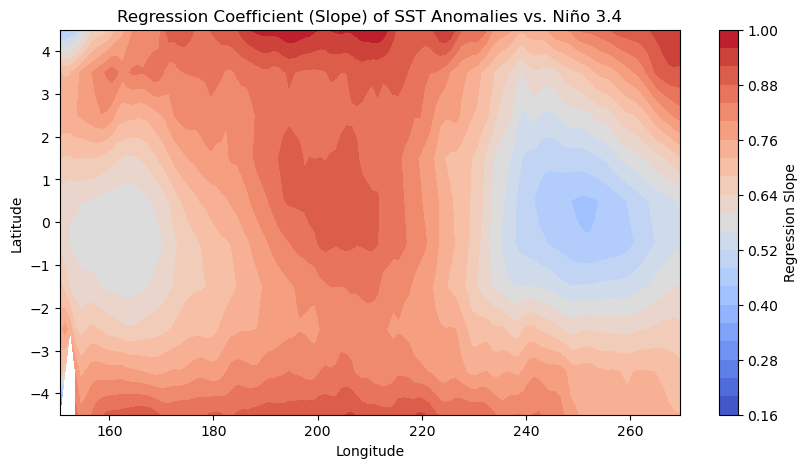

In [58]:
# Assuming you have access to the latitude and longitude arrays
# Example: lat and lon are arrays corresponding to the dimensions of ssta_data
# lat and lon should have shapes (latitude,) and (longitude,) respectively

# Example latitude and longitude arrays
# Replace these with actual data from your dataset
lat = ssta.coord('latitude').points
lon = ssta.coord('longitude').points

# Ensure that lat and lon match the dimensions of your slope_2d_reshaped
if len(lat) != slope_2d_reshaped.shape[0] or len(lon) != slope_2d_reshaped.shape[1]:
    raise ValueError("Latitude or Longitude dimensions do not match slope dimensions.")

# Create the contour plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(lon, lat, slope_2d_reshaped, cmap='coolwarm', levels=20)
plt.colorbar(contour, label='Regression Slope')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regression Coefficient (Slope) of SST Anomalies vs. Niño 3.4')
plt.show()


# Select December

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

# Assuming model_datasets_prep1 and model_datasets_prep2 are your data containers
nino34 = model_datasets_prep1["ACCESS-ESM1-5"]
ssta = model_datasets_prep2["ACCESS-ESM1-5"]

# Extract the time coordinate from ssta and nino34
time_ssta = ssta.coord('time')
time_nino34 = nino34.coord('time')


In [129]:
import iris
import pandas as pd
import numpy as np

# Assuming 'ssta' is an iris cube
time_coord = ssta.coord('time')
time_points = time_coord.points

# Extract units from the time coordinate
units = time_coord.units
units_str = str(units)  # Convert the Unit object to a string

# Extract reference date
reference_date_str = units_str.split(' since ')[1]
reference_date = pd.to_datetime(reference_date_str)

# Convert time_points to datetime
dates = reference_date + pd.to_timedelta(time_points, unit='D')

# Filter for December
december_dates = dates[dates.month == 12]

print("December Dates:", december_dates)


December Dates: DatetimeIndex(['1979-12-16 12:00:00', '1980-12-16 12:00:00',
               '1981-12-16 12:00:00', '1982-12-16 12:00:00',
               '1983-12-16 12:00:00', '1984-12-16 12:00:00',
               '1985-12-16 12:00:00', '1986-12-16 12:00:00',
               '1987-12-16 12:00:00', '1988-12-16 12:00:00',
               '1989-12-16 12:00:00', '1990-12-16 12:00:00',
               '1991-12-16 12:00:00', '1992-12-16 12:00:00',
               '1993-12-16 12:00:00', '1994-12-16 12:00:00',
               '1995-12-16 12:00:00', '1996-12-16 12:00:00',
               '1997-12-16 12:00:00', '1998-12-16 12:00:00',
               '1999-12-16 12:00:00', '2000-12-16 12:00:00',
               '2001-12-16 12:00:00', '2002-12-16 12:00:00',
               '2003-12-16 12:00:00', '2004-12-16 12:00:00',
               '2005-12-16 12:00:00', '2006-12-16 12:00:00',
               '2007-12-16 12:00:00', '2008-12-16 12:00:00',
               '2009-12-16 12:00:00', '2010-12-16 12:00:00',
        

In [158]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

# Assuming ssta is an iris cube
time_coord = ssta.coord('time')
time_points = time_coord.points

# Extract units from the time coordinate
units = time_coord.units
units_str = str(units)  # Convert the Unit object to a string

# Extract reference date
reference_date_str = units_str.split(' since ')[1]
reference_date = pd.to_datetime(reference_date_str)

# Convert time_points to datetime
dates = reference_date + pd.to_timedelta(time_points, unit='D')

# Filter for December
december_dates = dates[dates.month == 12]
december_indices = np.where(dates.month == 12)[0]

# Subset the ssta cube for December entries
ssta_december = ssta[december_indices]

# Compute the mean along the 'time' dimension
ssta_december_mean = ssta_december.collapsed('time', iris.analysis.MEAN)

ssta_december_std = np.std(ssta_december.data, axis=0)  # Compute std deviation along the 'time' axis
ssta_december_skew = skew(ssta_december.data, axis=0, nan_policy='omit')  # Compute skewness along the 'time' axis


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2164: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(


In [164]:
# Extract data and coordinates
data = ssta_december_skew  # NumPy array
lat = ssta_december_mean.coord('latitude').points
lon = ssta_december_mean.coord('longitude').points


/jobfs/124990957.gadi-pbs/ipykernel_1745860/3884449779.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='SST Anomalies')


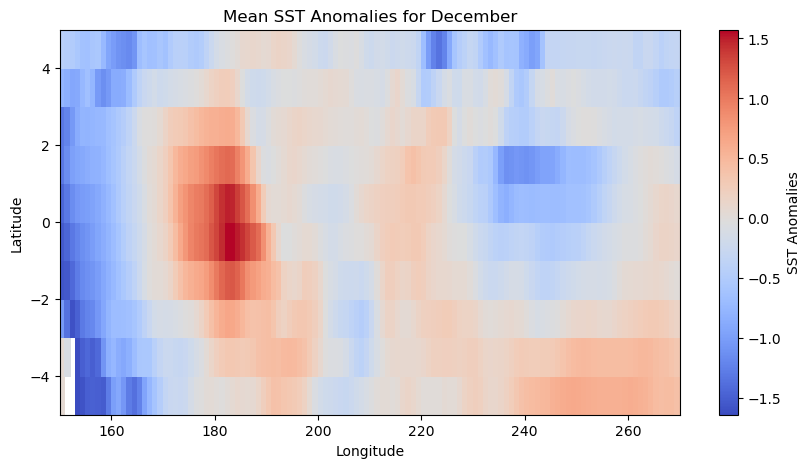

In [166]:
# Create a meshgrid for plotting
lon2D, lat2D = np.meshgrid(lon, lat)

# Plotting using pcolor
plt.figure(figsize=(10, 5))
plt.pcolor(lon2D, lat2D, data, cmap='coolwarm', shading='auto')
plt.colorbar(label='SST Anomalies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean SST Anomalies for December')
plt.show()